# Radius Valley Slope Estimation - Gap Bin Method - Period

The Gap Bin method is a piecewise segmentation that creates distinct bi-modal distributions for measuring points along the radius valley gap. This method involves segmenting the data for the horizontal axis, whether orbital period, insolation flux or stellar mass, into distinct groups. We used a 2D power law formula $R_p = X^me^{R_{p0}}$ and estimates the slope $m$ and $R_{p0}$ intercept using the Gap Bin slope measurement process with additional filtering and statistical methods to reduce computational biases and determine uncertainties. Specifically, $X$ could be either horizontal parameter $P$ (orbital period), $S_p$ (planet insolation flux) or $M_⁎$ (stellar mass), where $R_{p0}$ is the value of $R_p$ where the line intercepts the horizontal axis at $X = 0$. The complete analysis process for all planetary and stellar parameters is as follows:

1. Using this notebook, convert all data to log-log values so the slope can be estimated and visualized in log-log scale.

2. Use the Gap Bin method for group sizes ranging from 1 to 20 and for bin sizes ranging from 10 to 60. In theory, this can generate over 3000 slope data points, but there will be group and bin size combinations where bi-modal Gaussian curves cannot be generated. In general, there will usually be 100 to 2000 data points available for statistical analysis.

3. Remove data outliers using interquartile range (IQR) filtering where we calculate the IQR value. We then take 1.5 times the IQR and subtract this value from 1st quartile (Q1) and add this value to the 3rd quartile (Q3) to establish outlier thresholds. Any data points less than 1.5IQR below Q1 or more than 1.5IQR above Q3 are considered outliers and discarded.

4. Use linear regression as a sanity check to get initial slope and intercept which can be used as an initial guess for step 5.

5. Then use Bayesian methods to estimate the final slope and the associated uncertainties. Bayesian methods are preferred due to the proven accuracy of Affine Invariant Markov Chain Monte Carlo (MCMC) Ensemble sampling used with the $emcee$ Python module. See **RV_Slope_{x-axis}** notebooks, where **{x-axis}** can be **Period**, **Flux** or **Mass**.

6. Overlay the results of the Bayesian method to determine the slope and intercept for the 2D power law equation on the KDE contour plot of the sample planets for each horizontal parameter (i.e., orbital period, insolation flux or stellar mass). See **RV_KDE_Plots** notebook.

7. Repeat steps 2 through 6 using a filtered sample of stellar masses between 0.8 and 1.2 $M_⊙$ to see if planets with host stars near 1 $M_⊙$ show better alignment to model data or previous observational studies. Set **MASS_FILTER = False** for full sample and **MASS_FILTER = True** for filtered sample.

This Python notebook is used for steps 1-4 of the Radius Valley slope estimation process and requires the **RV_Planets_Final.csv** file. The primary output files to be used in Step 5 are **Slope_Data_P_IQR.csv** (full sample) and **Slope_Data_P_IQR_f.csv** (filtered sample).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [2]:
## Set Mass Filter flag for filtered sample between 0.8 to 1.2 Msun
MASS_FILTER = False

## Planet Data
Get planet data from file generated via NASA data with SEDmc estimated values for Rstar, Teff. Rp and Sp are calculated using standard astronomy formulas.

In [3]:
planets = pd.read_csv('RV_Planets_Final.csv')

planets.shape

(1923, 4)

In [4]:
planets

,P,Ms,Rp,Sp
0,4.040295,1.10,1.357232,493.538576
1,9.573083,1.10,2.319059,156.506927
2,6.398042,0.73,2.887246,43.733901
3,18.879740,0.73,2.542610,10.332839
4,1.628931,0.18,1.063102,19.553923
...,...,...,...,...
1918,4.562546,1.06,1.523677,357.863796
1919,15.872090,1.27,3.364782,152.329696
1920,8.327270,0.87,1.936520,71.197512
1921,2.698280,0.71,1.249594,206.909405


## Filter Sample
Set MASS_FILTER flag to determine if full sample or filtered sample is used

In [5]:
## Filter Sample to focus in smaller Mass Range
if MASS_FILTER == True:
    planets = planets[planets.Ms > 0.8]
    planets = planets[planets.Ms < 1.2]
    planets.reset_index(drop=True, inplace=True)
    planets.describe()

In [6]:
# Create Radius vs Orbital Period table

RvP = pd.DataFrame().assign(Rp=planets['Rp'], P=planets['P'])
RvP = RvP.dropna()
RvP

,Rp,P
0,1.357232,4.040295
1,2.319059,9.573083
2,2.887246,6.398042
3,2.542610,18.879740
4,1.063102,1.628931
...,...,...
1918,1.523677,4.562546
1919,3.364782,15.872090
1920,1.936520,8.327270
1921,1.249594,2.698280


In [7]:
RvP.describe()

,Rp,P
count,1923.000000,1923.000000
mean,2.365320,17.215121
std,0.683601,18.217248
min,1.000584,1.003934
25%,1.773074,5.349993
50%,2.401656,10.495711
75%,2.858245,21.223025
max,3.992935,99.640161


In [8]:
## Add Log value columns for slope estimation
RvP[['Rp_log', 'P_log']] = np.log(RvP[['Rp', 'P']])
RvP = RvP.sort_values(by=['P_log'], ignore_index=True)
RvP_log = pd.DataFrame(RvP, columns = ['Rp_log', 'P_log'])
RvP_log.to_csv('RvP_log.csv', index=False)
RvP_log

,Rp_log,P_log
0,0.569680,0.003926
1,0.539585,0.008003
2,0.275963,0.025541
3,0.292164,0.038389
4,0.325149,0.044613
...,...,...
1918,1.306417,4.566116
1919,1.118470,4.571396
1920,0.877142,4.573836
1921,0.616654,4.597673


In [9]:
RvP.describe()

,Rp,P,Rp_log,P_log
count,1923.000000,1923.000000,1923.000000,1923.000000
mean,2.365320,17.215121,0.815804,2.374782
std,0.683601,18.217248,0.307925,0.990589
min,1.000584,1.003934,0.000583,0.003926
25%,1.773074,5.349993,0.572715,1.677095
50%,2.401656,10.495711,0.876159,2.350967
75%,2.858245,21.223025,1.050208,3.055087
max,3.992935,99.640161,1.384527,4.601565


## RV Slope Analysis - Gap Bin Code Development & Testing
The next several sections were used to progressivly develop the Gap Bin method and can still be use for testing and debugging

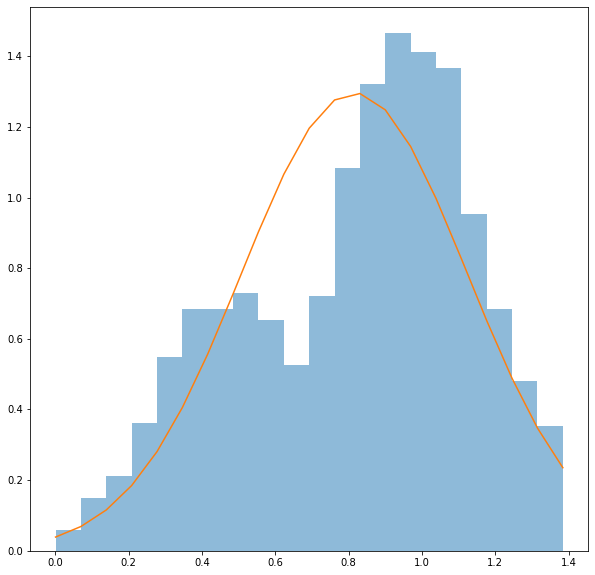

In [10]:
from scipy import stats
plt.figure(figsize=(10,10))
_, bins, _ = plt.hist(RvP.Rp_log, 20, density=1, alpha=0.5)
mu, sigma = stats.norm.fit(RvP.Rp_log)
best_fit_line = stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)

## Initial Bimodal Code
Initial code used to create bimodal Gaussian curve from planet Rp distribution

Modified code from
https://stackoverflow.com/questions/35990467/fit-mixture-of-two-gaussian-normal-distributions-to-a-histogram-from-one-set-of

Rp_log = 0.613;  P_log_mid = 2.303
Rp = 1.847;  P_mid = 10.002
            params     sigma
mu1       0.413671  0.013535
sigma1    0.154487  0.013179
A1       60.974593  3.310631
mu2       0.972394  0.007107
sigma2    0.201618  0.008025
A2      130.243059  2.970400


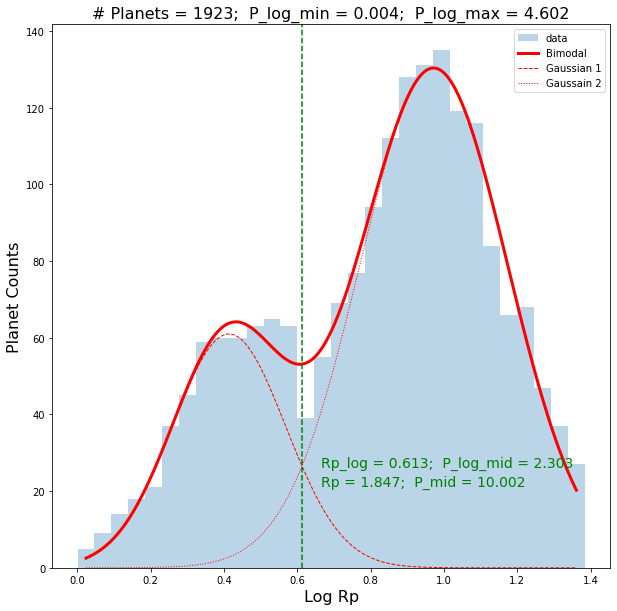

In [11]:
from scipy.optimize import curve_fit

#Define data to be used
plt.figure(figsize=(10,10))
data = RvP.Rp_log
P_mid = (RvP['P_log'].max() + RvP['P_log'].min()) / 2
y,x,_= plt.hist(data, 30, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

# Estimate expected values for gaussian parameters
hist_data = np.vstack((x, y)).T
A1 = hist_data[0:int(len(hist_data)/2)].max(axis=0)[1]
mu1 = hist_data[np.where(hist_data[:,1] == A1)][0][0]
sigma1 = (hist_data[0:int(len(hist_data)/2)][-1][0] - mu1) / 2
A2 = hist_data[int(len(hist_data)/2):-1].max(axis=0)[1]
mu2 = hist_data[np.where(hist_data[:,1] == A2)][0][0]
sigma2 = (hist_data[int(len(hist_data)/2):-1][-1][0] - mu2) / 2

#Get actual values for gaussian parameter
expected = (mu1, sigma1, A1, mu2, sigma2, A2)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)

#plot combined...
plt.xlabel('Log Rp', fontsize=16)
plt.ylabel('Planet Counts', fontsize=16)
plt.title('# Planets = ' + str(len(data)) + ';  P_log_min = ' + str(round(RvP.P_log.min(),3))
          + ';  P_log_max = ' + str(round(RvP.P_log.max(),3)), fontsize=16)
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='Bimodal')

#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='Gaussian 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='Gaussain 2')

#and the original data points if no histogram has been created before
gauss_data = pd.DataFrame(data={'Rp': x_fit, 'gauss1': gauss(x_fit, *params[:3]), 'gauss2': gauss(x_fit, *params[3:])})
gauss_eq = gauss_data.iloc[(gauss_data.gauss1 - gauss_data.gauss2).abs().argsort()[:1]]
Rp_min = gauss_eq.iloc[0]['Rp']
gauss_min = gauss_eq.iloc[0]['gauss1']
plt.axvline(Rp_min, color = 'g', linestyle = '--')
plt.text(Rp_min+.05, gauss_min, 'Rp_log = ' + str(round(Rp_min,3)) + ';  P_log_mid = ' + str(round(P_mid,3)), fontsize=14, c='g')
plt.text(Rp_min+.05, gauss_min-5, 'Rp = ' + str(round(np.exp(Rp_min),3)) + ';  P_mid = ' + str(round(np.exp(P_mid),3)), fontsize=14, c='g')
plt.legend()
print('Rp_log = ' + str(round(Rp_min,3)) + ';  P_log_mid = ' + str(round(P_mid,3)))
print('Rp = ' + str(round(np.exp(Rp_min),3)) + ';  P_mid = ' + str(round(np.exp(P_mid),3)))
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
slope_data1 = pd.DataFrame(data={'Rp_log': Rp_min, 'P_log_mid': P_mid, 'Rp': np.exp(Rp_min), 'P_mid': np.exp(P_mid)}, index=[0])
plt.show() 

In [12]:
## Intial method to find center of group
gauss_data = pd.DataFrame(data={'Rp': x_fit, 'gauss1': gauss(x_fit, *params[:3]), 'gauss2': gauss(x_fit, *params[3:])})
#gauss_data
#gauss_eq = gauss_data[min(gauss_data.gauss1 - gauss_data.gauss2)]
gauss_eq = gauss_data.iloc[(gauss_data.gauss1 - gauss_data.gauss2).abs().argsort()[:1]]

Rp_min = gauss_eq.iloc[0]['Rp']
Rp_min
gauss_min = gauss_eq.iloc[0]['gauss1']
gauss_min
P_center = (RvP['P_log'].max()- RvP['P_log'].min()) / 2
P_center

2.2988196415669235

In [13]:
## Find group size and range for given number of groups
grps = 6
i=1
grp_siz = int(len(RvP) / grps) + 1
RvP_grp = RvP.loc[(i-1)*grp_siz:i*grp_siz-1]
print(grp_siz, grps * grp_siz, (i-1)*grp_siz, i*grp_siz-1)
RvP_grp

321 1926 0 320


,Rp,P,Rp_log,P_log
0,1.767701,1.003934,0.569680,0.003926
1,1.715295,1.008035,0.539585,0.008003
2,1.317799,1.025870,0.275963,0.025541
3,1.339322,1.039135,0.292164,0.038389
4,1.384237,1.045623,0.325149,0.044613
...,...,...,...,...
316,1.190355,3.975998,0.174251,1.380276
317,2.374205,3.984420,0.864663,1.382392
318,1.262181,3.989540,0.232841,1.383676
319,2.718557,4.014570,1.000101,1.389930


0.6694892993903421
65.0 0.5310949869143917 0.13614608617700938
1.3153294242781104
135.0 0.9924093618342262 0.13614608617700938


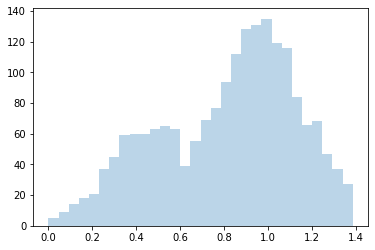

In [14]:
# Find parameters for both Gaussian curves for all planets
y,x,_= plt.hist(data, 30, alpha=.3, label='data')
#x1 = x[0:len(x)-1]
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
hist_data = np.vstack((x, y)).T
#print(np.shape(x1), type(x1))
#print(np.shape(hist_data), type(hist_data))
A1 = hist_data[0:int(len(hist_data)/2)].max(axis=0)[1]
#idx = np.where(hist_data[:,1] == A1)
mu1 = hist_data[np.where(hist_data[:,1] == A1)][0][0]
#sigma1 = (hist_data[0:int(len(hist_data)/2)][-1][0] - mu1) / 2
sigma1 = hist_data[-1][0]*.1
print(hist_data[0:int(len(hist_data)/2)][-1][0])
print(A1, mu1, sigma1)
A2 = hist_data[int(len(hist_data)/2):-1].max(axis=0)[1]
mu2 = hist_data[np.where(hist_data[:,1] == A2)][0][0]
#sigma2 = (hist_data[int(len(hist_data)/2):-1][-1][0] - mu2) / 2
sigma2 = hist_data[-1][0]*.1
print(hist_data[int(len(hist_data)/2):-1][-1][0])
print(A2, mu2, sigma2)
#hist_data

In [15]:
RvP.describe()

,Rp,P,Rp_log,P_log
count,1923.000000,1923.000000,1923.000000,1923.000000
mean,2.365320,17.215121,0.815804,2.374782
std,0.683601,18.217248,0.307925,0.990589
min,1.000584,1.003934,0.000583,0.003926
25%,1.773074,5.349993,0.572715,1.677095
50%,2.401656,10.495711,0.876159,2.350967
75%,2.858245,21.223025,1.050208,3.055087
max,3.992935,99.640161,1.384527,4.601565


## Test Bimodal Code - 1 Group Size
Test Bimodal code for 1 group size. Use Group Size = 6 and Bin Size = 30
Need to manually change i for each group plot and final slope data

28.0 0.46359523438763417 0.06740775457099546
9.0 0.9501031557553854 0.06740775457099546
Rp_log = 0.238;  P_log_mid = 0.697
Rp = 1.268;  P_mid = 2.008
           params     sigma
mu1      0.428674  0.018453
sigma1   0.121792  0.024155
A1      18.031915  2.835470
mu2      0.711077  0.141993
sigma2   0.476380  0.119679
A2       8.664037  1.918657


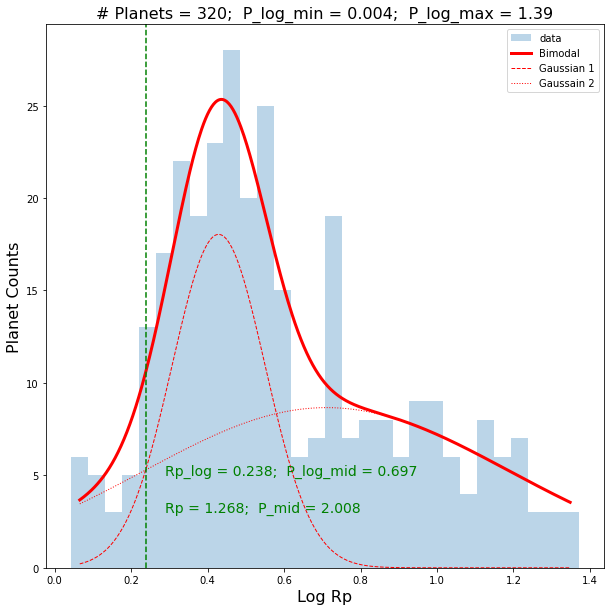

In [16]:
from scipy.optimize import curve_fit

#x, y inputs can be lists or 1D numpy arrays
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

# Create Data Groups
bins = 30
grps = 6
i=1
grp_siz = int(len(RvP) / grps) + 1
RvP_grp = RvP.iloc[(i-1)*grp_siz:i*grp_siz-1]
#print(grp_siz, grps * grp_siz, (i-1)*grp_siz, i*grp_siz-1)
#RvP_grp

# Create Histogram and get data
plt.figure(figsize=(10,10))
data = RvP_grp.Rp_log
P_mid = (RvP_grp['P_log'].max() + RvP_grp['P_log'].min()) / 2
y,x,_= plt.hist(data, bins, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

# Estimate expected values for gaussian parameters
hist_data = np.vstack((x, y)).T
A1 = hist_data[0:int(len(hist_data)/2)-3].max(axis=0)[1] #Peak for bins < 8 bins from center
mu1 = hist_data[np.where(hist_data[:,1] == A1)][0][0] #Set mean to location of peak
sigma1 = hist_data[-1][0] * 0.05  # Set sigma to 5% of max bin location
print(A1, mu1, sigma1)
A2 = hist_data[int(len(hist_data)/2)+4:-1].max(axis=0)[1] #Peak for bins > 8 bins from center
mu2 = hist_data[np.where(hist_data[:,1] == A2)][0][0] #Set mean to location of peak
sigma2 = hist_data[-1][0] * 0.05 # Set sigma to 5% of max bin location
print(A2, mu2, sigma2)

#Get actual values for gaussian parameter
expected = (mu1, sigma1, A1, mu2, sigma2, A2)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)

#plot combined...
plt.xlabel('Log Rp', fontsize=16)
plt.ylabel('Planet Counts', fontsize=16)
plt.title('# Planets = ' + str(len(data)) + ';  P_log_min = ' + str(round(RvP_grp.P_log.min(),3))
          + ';  P_log_max = ' + str(round(RvP_grp.P_log.max(),3)), fontsize=16)
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='Bimodal')

#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='Gaussian 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='Gaussain 2')

#and the original data points if no histogram has been created before
gauss_data = pd.DataFrame(data={'Rp': x_fit, 'gauss1': gauss(x_fit, *params[:3]), 'gauss2': gauss(x_fit, *params[3:])})
gauss_eq = gauss_data.iloc[(gauss_data.gauss1 - gauss_data.gauss2).abs().argsort()[:1]]
Rp_min = gauss_eq.iloc[0]['Rp']
gauss_min = gauss_eq.iloc[0]['gauss1']
plt.axvline(Rp_min, color = 'g', linestyle = '--')
plt.text(Rp_min+.05, 5, 'Rp_log = ' + str(round(Rp_min,3)) + ';  P_log_mid = ' + str(round(P_mid,3)), fontsize=14, c='g')
plt.text(Rp_min+.05, 3, 'Rp = ' + str(round(np.exp(Rp_min),3)) + ';  P_mid = ' + str(round(np.exp(P_mid),3)), fontsize=14, c='g')
plt.legend()
print('Rp_log = ' + str(round(Rp_min,3)) + ';  P_log_mid = ' + str(round(P_mid,3)))
print('Rp = ' + str(round(np.exp(Rp_min),3)) + ';  P_mid = ' + str(round(np.exp(P_mid),3)))
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
#slope_data = pd.DataFrame(data={'Rp_log': Rp_min, 'P_log_mid': P_mid, 'Rp': np.exp(Rp_min), 'P_mid': np.exp(P_mid)}, index=[i])
slope_data1.loc[i] = [Rp_min, P_mid, np.exp(Rp_min), np.exp(P_mid)]
plt.show() 

## Estimate RV Slope for Initial Group Tests
Use linear regression to find slope from bimodal group analysis

0.2339669578443099 0.07469955260655775


,Rp_log,P_log_mid,Rp,P_mid
0,0.613466,2.302746,1.846821,10.001606
1,0.237758,0.696928,1.268402,2.007576


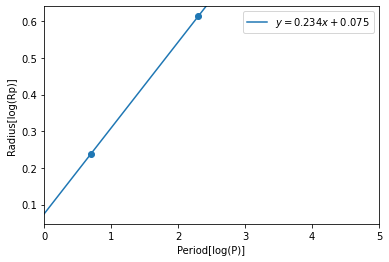

In [17]:
m, b, r_value, p_value, std_err = stats.linregress(slope_data1.P_log_mid[0:6],slope_data1.Rp_log[0:6])
print(m, b)
plt.xlim(0, 5)
#plt.ylim(0, 1.5)
plt.xlabel('Period[log(P)]', fontsize=10)
plt.ylabel('Radius[log(Rp)]', fontsize=10)
plt.scatter(slope_data1.P_log_mid[0:6],slope_data1.Rp_log[0:6])
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.3f}x {b:+.3f}$')
plt.legend()
slope_data1

In [18]:
RvP_grp

,Rp,P,Rp_log,P_log
0,1.767701,1.003934,0.569680,0.003926
1,1.715295,1.008035,0.539585,0.008003
2,1.317799,1.025870,0.275963,0.025541
3,1.339322,1.039135,0.292164,0.038389
4,1.384237,1.045623,0.325149,0.044613
...,...,...,...,...
315,1.502851,3.970768,0.407364,1.378959
316,1.190355,3.975998,0.174251,1.380276
317,2.374205,3.984420,0.864663,1.382392
318,1.262181,3.989540,0.232841,1.383676


## Generate Slope Data - Range of Bin and Group Sizes
Final code to generate a large amount of slope data to better estimate slope, intercept with uncertianties

In [19]:
#Generate Slope Data for range of bins and groups
from scipy.optimize import curve_fit
from scipy.signal import argrelmin

#x, y inputs can be lists or 1D numpy arrays
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

num_bins=0
brk_typ = "Null"
bin_min, bin_max = 10, 60
grp_min, grp_max = 1, 20
idx = 0
brk_cnt = 0
slope_data = pd.DataFrame(data={'Rp_log': Rp_min, 'P_log_mid': P_mid, 'Rp': np.exp(Rp_min), \
                                'P_mid': np.exp(P_mid), 'bins': num_bins, 'grps': grps, 'i': i}, index=[idx])
brk_data = pd.DataFrame(data={'Rp_log': Rp_min, 'P_log_mid': P_mid, 'Rp': np.exp(Rp_min), \
                                'P_mid': np.exp(P_mid), 'bins': num_bins, 'grps': grps, 'i': i, 'type': brk_typ}, index=[brk_cnt])


for num_bins in range(bin_min, bin_max):
    for grps in range(grp_min, grp_max):
        for i in range(1,grps):
        
            # Create Data Groups
            grp_siz = int(len(RvP) / grps) + 1
            RvP_grp = RvP.iloc[(i-1)*grp_siz:i*grp_siz-1]
            #print(bin_siz, grps, i, grp_siz, grps * grp_siz, (i-1)*grp_siz, i*grp_siz-1)
            #RvP_grp

            # Create Histogram and get data
            data = RvP_grp.Rp_log
            P_mid = (RvP_grp['P_log'].max() + RvP_grp['P_log'].min()) / 2
            y,x = np.histogram(data, num_bins)
            x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
            x_mid = (x.max() - x.min())/2 + x.min()

            # Estimate expected values for gaussian parameters
            hist_data = np.vstack((x, y)).T
            A1 = hist_data[0:int(len(hist_data)/2)-int(num_bins/5)].max(axis=0)[1] #Peak for bins < bins/5 from center
            mu1 = hist_data[np.where(hist_data[:,1] == A1)][0][0] #Set mean to location of peak
            sigma1 = hist_data[-1][0] * 0.05  # Set sigma to 5% of max bin location
            #print(A1, mu1, sigma1)
            A2 = hist_data[int(len(hist_data)/2)+int(num_bins/5):-1].max(axis=0)[1] #Peak for bins > bins/5 from center
            mu2 = hist_data[np.where(hist_data[:,1] == A2)][0][0] #Set mean to location of peak
            sigma2 = hist_data[-1][0] * 0.05 # Set sigma to 5% of max bin location
            #print(A2, mu2, sigma2)

            #Get actual values for gaussian parameter
            expected = (mu1, sigma1, A1, mu2, sigma2, A2)
            try: 
                params, cov = curve_fit(bimodal, x, y, expected)
            except RuntimeError:
                brk_typ = "Bimodal"
                brk_data.loc[brk_cnt] = [Rp_min, P_mid, np.exp(Rp_min), np.exp(P_mid), num_bins, grps, i, brk_typ]
                brk_cnt += 1
                break
            sigma=np.sqrt(np.diag(cov))

            # Check for valid params to generate bimodal with valid minima
            # Check if mu1 and mu2 are in proper regions of distribution
            if params[0] > x_mid or params[3] < x_mid:
                brk_typ = "Region"
                brk_data.loc[brk_cnt] = [Rp_min, P_mid, np.exp(Rp_min), np.exp(P_mid), num_bins, grps, i, brk_typ]
                brk_cnt += 1
                break
           
            # Check for valid minima of bimodal
            bimodal_data = bimodal(x_fit, *params)
            bm_min = argrelmin(bimodal_data)
            if len(bm_min[0]) == 0:
                brk_typ = "No_Min"
                brk_data.loc[brk_cnt] = [Rp_min, P_mid, np.exp(Rp_min), np.exp(P_mid), num_bins, grps, i, brk_typ]
                brk_cnt += 1
                break
            else:
                Rp_min = ((x.max() - x.min()) / 500 * bm_min[0][0]) + x.min()

            # Add to slope data
            slope_data.loc[idx] = [Rp_min, P_mid, np.exp(Rp_min), np.exp(P_mid), num_bins, grps, i]
            idx += 1

if MASS_FILTER == True:
    ## Use Filtered slope data for further filtering and analysis
    slope_data.to_csv('Slope_Data_P_F.csv', index=False)
    ## Use Filtered Break data for troubleshooting failed attempts to measure slope
    brk_data.to_csv('Break_Data_P_F.csv', index=False)
else:
    ## Use slope data for further filtering and analysis
    slope_data.to_csv('Slope_Data_P.csv', index=False)
    ## Use Break data for troubleshooting failed attempts to measure slope
    brk_data.to_csv('Break_Data_P.csv', index=False)

-0.16155598382907096 0.9148133284086868


(238, 7)

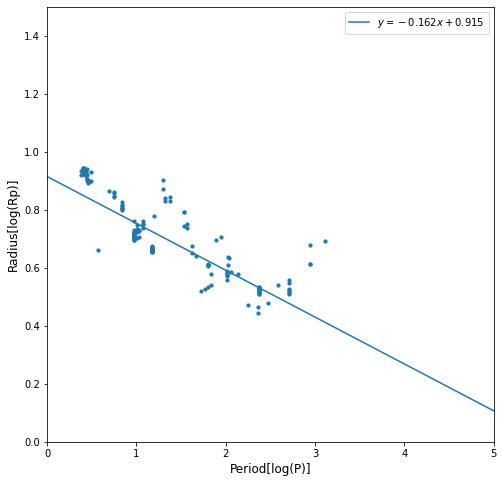

In [20]:
## Plot initial linear regression slope 
m, b, r_value, p_value, std_err = stats.linregress(slope_data.P_log_mid,slope_data.Rp_log)
print(m, b)
plt.figure(figsize=(8, 8))
plt.xlim(0, 5)
plt.ylim(0, 1.5)
plt.xlabel('Period[log(P)]', fontsize=12)
plt.ylabel('Radius[log(Rp)]', fontsize=12)
plt.scatter(slope_data.P_log_mid,slope_data.Rp_log, s=10)
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.3f}x {b:+.3f}$')
plt.legend()
slope_data.shape

## Filter Slope Data
use IRQ filtering method to eliminate outliers

In [21]:
slope_data_IQR = slope_data
print("Old Shape: ", slope_data_IQR.shape)

# IQR
# Calculate the upper and lower limits
Q1 = slope_data_IQR['Rp_log'].quantile(0.25)
Q3 = slope_data_IQR['Rp_log'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
# Create arrays of Boolean values indicating the outlier rows
upper_array = np.where(slope_data_IQR['Rp_log'] >= upper)[0]
lower_array = np.where(slope_data_IQR['Rp_log'] <= lower)[0]
 
# Removing the outliers
slope_data_IQR.drop(index=upper_array, inplace=True)
slope_data_IQR.drop(index=lower_array, inplace=True)
 
# Print the new shape of the DataFrame
print("New Shape: ", slope_data_IQR.shape)
# Save Data to File for further analysis
if MASS_FILTER == True:
    slope_data_IQR.to_csv('Slope_Data_P_IQR_f.csv', index=False)
else:
    slope_data_IQR.to_csv('Slope_Data_P_IQR.csv', index=False)

Old Shape:  (238, 7)
New Shape:  (238, 7)


In [ ]:
## Plot IRQ filtered linear regression slope 
m, b, r_value, p_value, std_err = stats.linregress(slope_data_IQR.P_log_mid,slope_data_IQR.Rp_log)
print(m, b)
plt.figure(figsize=(8, 8))
# plt.plot([1,100], [ymax, ymin], 'r', linestyle="--")
plt.xlim(0, 5)
plt.ylim(0, 1.5)
plt.xlabel('Period[log(P)]', fontsize=12)
plt.ylabel('Radius[log(Rp)]', fontsize=12)
plt.scatter(slope_data_IQR.P_log_mid,slope_data_IQR.Rp_log, s=10)
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.3f}x {b:+.3f}$')
plt.legend()